In [ ]:
import os
from pyrosm import OSM
import osmnx as ox
import geopandas as gpd
import pandas as pd
import uuid
import matplotlib.pyplot as plt

#project specific packages
import services.network_bands as network_bands
import services.batch_csv as batch_csv
import services.census as census

In [ ]:
#https://build.nisra.gov.uk/en/custom/data?d=HOUSEHOLD&v=DZ21&v=HH_LIFESTAGE_AGG15

In [ ]:
#set base directory for data file paths.
base_dir = os.getcwd()

In [ ]:
# create network graph and edges.
base_road_path = f'{base_dir}\\testEnvironment\\Data\\belfast_slightly_trimmed.osm.pbf'
G, nodes, edges = network_bands.load_osm_network(file_path=base_road_path, network_type='driving', graph_type='networkx')

In [ ]:
#Start locations
start_locations = pd.read_csv(f'{base_dir}\\testEnvironment\\Data\\libraries_belfast_2024.csv')
print(start_locations.columns)
#Ensure data is converted to a dataframe
start_locations_gdf = network_bands.csv_to_gdf(start_locations, 'X COORDINATE', 'Y COORDINATE', 29902, 4326)

In [ ]:
#Create the network areas and contours - Considering making this into a Class with basic GUI, but for now fine as this.
start_locations_nearest_node = network_bands.nearest_node_and_name(G, start_locations=start_locations_gdf,  
                                                                   location_name = 'Static Library Name')

#Create service areas for each distance. Remember, these overlap, good for counting checking how close 
#input custom distances as a list.
search_distances = [1000,2000,3000]
#Create individual network areas around start locations. alpha area of 500 quite good for Belfast
network_areas = network_bands.network_areas(nearest_node_dict=start_locations_nearest_node, graph=G, 
                                                    search_distances=search_distances, alpha_value=500, weight = 'length', progress=True)
#Create network area contours by dissolving and differencing polygons based on distance.
network_contours = network_bands.network_contours(network_areas, dissolve_cat='distance',aggfunc='first', show_graph=True)

In [181]:
#Load in data zones from 2021 census
#Ensure evrything's in 4326 for network analysis, probably can change it back to tm65.
data_zones = gpd.read_file(f'{base_dir}\\testEnvironment\\Data\\DZ2021.shp')
data_zones.to_crs(4326, inplace=True)
#extract only belfast datazones
belfast_zones = data_zones[data_zones['LGD2014_nm'] == 'Belfast']
#very, very small simplify needed if joins are required. THe current Data Zone polygons from OSNI have loads of small geometry errors
#the simplify allows spatial join to function properly without. A bit of a bodge.
belfast_zones.to_crs(29902, inplace=True)
belfast_zones['geometry'] = belfast_zones['geometry'].simplify(tolerance = 0.001, preserve_topology=True)

#Load in house data 
pointer = gpd.read_file(f'{base_dir}\\testEnvironment\\Data\\pointer_randomised.shp')
pointer['uuid'] = pointer.apply(lambda i: uuid.uuid4(), axis=1)
pointer.to_crs(4326, inplace=True)
belfast_zones.to_crs(pointer.crs)

,DZ2021_cd,DZ2021_nm,SDZ2021_cd,SDZ2021_nm,LGD2014_nm,geometry
710,N20000711,Oldpark_A1,N21000161,Oldpark_A,Belfast,"POLYGON ((-5.98558 54.65897, -5.98554 54.65895..."
711,N20000712,Oldpark_A2,N21000161,Oldpark_A,Belfast,"POLYGON ((-5.98748 54.62241, -5.98748 54.62241..."
712,N20000713,Oldpark_A3,N21000161,Oldpark_A,Belfast,"POLYGON ((-5.97900 54.62839, -5.97960 54.62877..."
713,N20000714,Oldpark_B1,N21000162,Oldpark_B,Belfast,"POLYGON ((-5.96441 54.62989, -5.96486 54.63013..."
714,N20000715,Oldpark_D1,N21000164,Oldpark_D,Belfast,"POLYGON ((-5.98875 54.62846, -5.98886 54.62841..."
...,...,...,...,...,...,...
1440,N20001441,Court_X3,N21000335,Court_X,Belfast,"POLYGON ((-5.96144 54.59517, -5.96158 54.59525..."
1441,N20001442,Court_T3,N21000332,Court_T,Belfast,"POLYGON ((-5.96576 54.59507, -5.96579 54.59508..."
1442,N20001443,Court_X4,N21000335,Court_X,Belfast,"POLYGON ((-5.95899 54.59542, -5.95904 54.59563..."
1443,N20001444,Court_W4,N21000334,Court_W,Belfast,"POLYGON ((-5.94299 54.59546, -5.94248 54.59537..."


In [182]:
# fig, ax = plt.subplots(figsize=(12,12))

# edges.plot(ax=ax, zorder=2)
# pointer.plot(ax=ax, color='black', zorder = 12, markersize=2)
# start_locations_gdf.plot(ax=ax, color='red', zorder=13, markersize=150)
# belfast_zones.plot(ax=ax, color='gray', zorder=11)


In [183]:
#Performa spatial join of pointer households and datazones in belfast
joined_gdf = gpd.sjoin(pointer, belfast_zones, how='inner', predicate='within')

# Count the points per data zone using 'index_right'  which = belfast_zones
point_counts = joined_gdf.groupby('index_right').size()
point_counts = point_counts.reset_index(name='actual_households')

# Merge the counts back to the belfast data zones GeoDataFrame, right_on =right as datazones are the right joined gdf.
belfast_zones = belfast_zones.merge(point_counts, how='left', left_index=True, right_on='index_right')
# Turn NaN to 0
belfast_zones['actual_households'] = belfast_zones['actual_households'].fillna(0).reset_index(drop=True)
if 'index_left' in belfast_zones.columns:
    belfast_zones.rename(columns={'index_left': 'zone_index_left'}, inplace=True)
if 'index_right' in belfast_zones.columns:
    belfast_zones.rename(columns={'index_right': 'zone_index_right'}, inplace=True)

In [184]:
#Load the Census data, file_paths in file_paths.
file_paths = [
    '/testEnvironment/Data/census_data/ni-2021-usual-residents.csv',
    '/testEnvironment/Data/census_data/ni-2021-households.csv',
    '/testEnvironment/Data/census_data/ni-2021-employment-deprivation.csv'
]
#extract each one from dataframe
loaded_csv = batch_csv.batch_csv_read(file_paths)

#check data is loaded loaded
print(loaded_csv.keys())

#force rename to maintain consistency of important join value column.
loaded_csv['ni-2021-employment-deprivation'].rename(columns={'Census 2021 Data Zone Code':'Geography code'}, inplace=True)

#OSNI data has irregular capitalisation, avoids this bug by forcing lower case. Some are 'Geography Code', 'geography Code' etc.
for key, df in loaded_csv.items():
    df.columns = df.columns.str.lower()
    
joined_census_data = census.join_census_csv(loaded_csv, 'geography code',  drop=True,join_type='left')

dict_keys(['ni-2021-usual-residents', 'ni-2021-households', 'ni-2021-employment-deprivation'])
The following columns were duplicates from the right join and were dropped: [['geography', 'access census area explorer'], []]


In [185]:
#Calculate CENSUS METRICS PER HOUSE in pointer data
#join the census data loaded 
belfast_zones = pd.merge(joined_census_data, belfast_zones, left_on='geography code', right_on='DZ2021_cd')
#Need to force these to numeric. Ensure coerce for any nulls
belfast_zones['all households'] = pd.to_numeric(belfast_zones['all households'], errors = 'coerce')
belfast_zones['all usual residents'] = pd.to_numeric(belfast_zones['all usual residents'], errors = 'coerce')

#the data from employment has it as count, renamed for clarity
belfast_zones.rename(columns={'count': 'employment_deprivation_count'}, inplace=True)

## Calculate your metrics. Average resident per house etc.
# actual household data has been extracted by spatial join of the randomised poitner dataset. 
#average residents per household
belfast_zones['avg_resi_house'] = (belfast_zones['all usual residents']/belfast_zones['actual_households'])
#average employment deprivation per household
belfast_zones['avg_emp_depri_per_house'] = belfast_zones['employment_deprivation_count']/belfast_zones['actual_households']
#average employment deprivation per person
belfast_zones['avg_emp_depri_per_capita'] = belfast_zones['employment_deprivation_count']/belfast_zones['all usual residents']

#Force to gdf, currently will be a panda series
belfast_zones = gpd.GeoDataFrame(belfast_zones)


In [189]:
#Spatial join to network_areas and then back to start locations (libraries)
#this will assess the types of households nearby.
pointer_metric_data = gpd.sjoin(pointer, belfast_zones, how='left', predicate='intersects')

159675
159675


C:\Users\hular\AppData\Local\Temp\ipykernel_21140\3905062306.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:29902

  pointer_metric_data = gpd.sjoin(pointer, belfast_zones, how='left', predicate='intersects')


<Axes: >

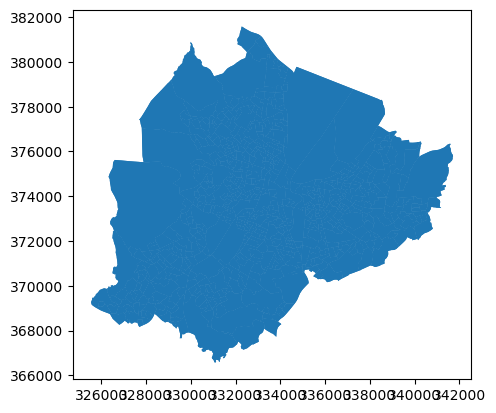

In [190]:
belfast_zones.plot()

In [188]:
# belfast_zones.to_crs(pointer.crs, inplace=True)
# join_result = gpd.sjoin(pointer, belfast_zones, how="left", op='intersects')
# join_result['geometry'] = join_result['geometry'].buffer(-0.0001)

# join_result
